In [1]:
# Imports
%matplotlib inline
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

/var/folders/9w/8jsv_f1j1t357nbjlwl197kr0000gn/T/ipykernel_77258/3015883455.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
high_quality = (c1 | c2) & c3 & c4
table_cut = table_cut[high_quality]
tab = table_cut
# objective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab_1 = smcnod

In [3]:
tab.write('smcnod.dat', format='ascii', overwrite=True)

In [17]:
len(tab)

370

In [19]:
len(tab_1)

150

In [20]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

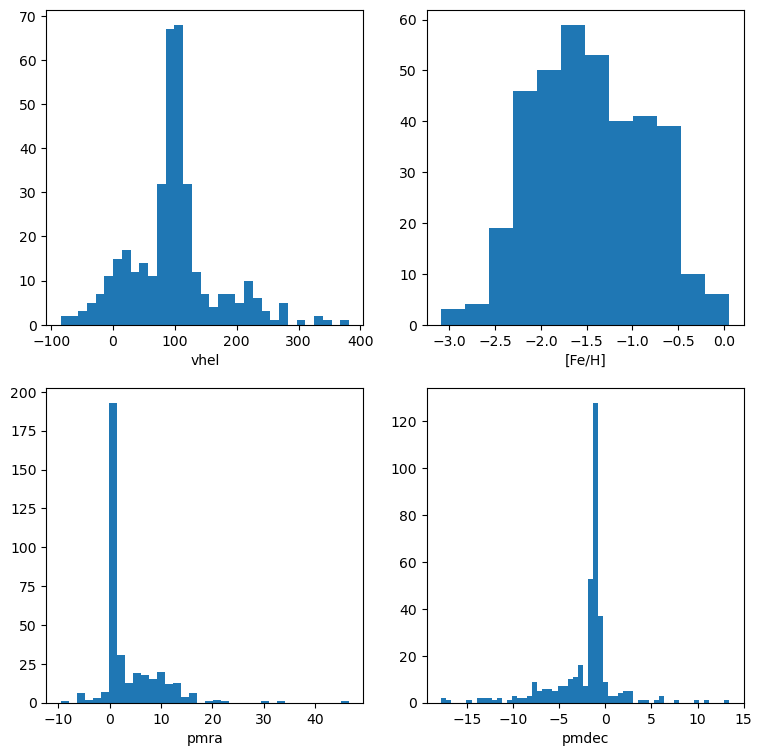

In [21]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In [22]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

In [23]:
data = dict(N=len(tab), pms=pms, 
            pmcovs=pmcovs, pmnorm=pmnorm)

In [24]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec"]

In [28]:
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # Let prior be cutoff of based on the histograms
    # fraction of stars, velocity dispersion, feh dispersion, velocity, proper motion
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pm = np.log(data["pmnorm"])
    lbg2_pm = np.log(data["pmnorm"])
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pm+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pm +lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

In [29]:
def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [30]:
# Also based on EDA eyeball results
p0_guess = [0.5, 0.7,
            98, 1, -2.2,-0.4,
            130, 2.0, -1, -0.5,
            10, 1.5, -0.7, -0.5,
            0.7, -1.1]

In [31]:
optfunc = lambda theta: -full_like(theta)
%timeit optfunc(p0_guess)

26.9 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
optfunc(p0_guess)

4318.97027388421

In [33]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 1min 21s, sys: 1.41 s, total: 1min 22s
Wall time: 1min 22s


In [34]:
res.x

array([  0.47009404,   0.62912657, 102.55976194,   1.38553819,
        -1.87199909,  -0.48708908, 132.49254162,   1.97595401,
        -1.24842309,  -0.39353914,  21.45892891,   1.54853927,
        -0.62685348,  -0.55421691,   0.70418182,  -1.12542582])

In [35]:
optfunc(res.x)

4162.54395777432

In [36]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.470
pbg1: 0.629
vhel: 102.560
lsigv: 1.386
feh: -1.872
lsigfeh: -0.487
vbg1: 132.493
lsigvbg1: 1.976
fehbg1: -1.248
lsigfeh1: -0.394
vbg2: 21.459
lsigvbg2: 1.549
fehbg2: -0.627
lsigfeh2: -0.554
pmra: 0.704
pmdec: -1.125


In [42]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
nit = 2000
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # arbitrary width that's pretty close
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

16


In [43]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
es = emcee.EnsembleSampler(
    nwalkers, len(p0_guess), full_like)

In [44]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 51min 30s, sys: 20.6 s, total: 51min 51s
Wall time: 51min 51s


In [47]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
np.save("results_smcnod.npy",es.flatchain)

CPU times: user 49min 56s, sys: 20.1 s, total: 50min 16s
Wall time: 50min 13s


In [48]:
outputs = es.flatchain

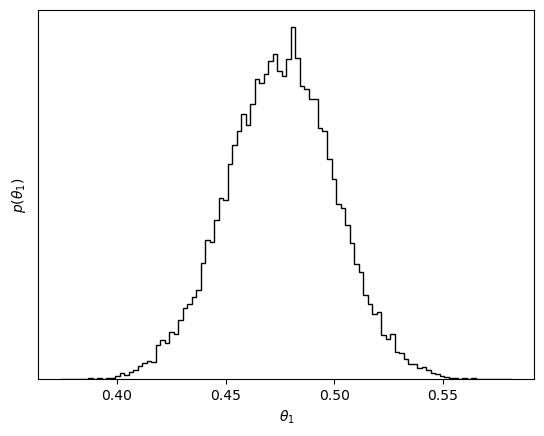

In [49]:
# samples can be accessed using the EnsembleSampler.get_chain() method
samples = es.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [51]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.318


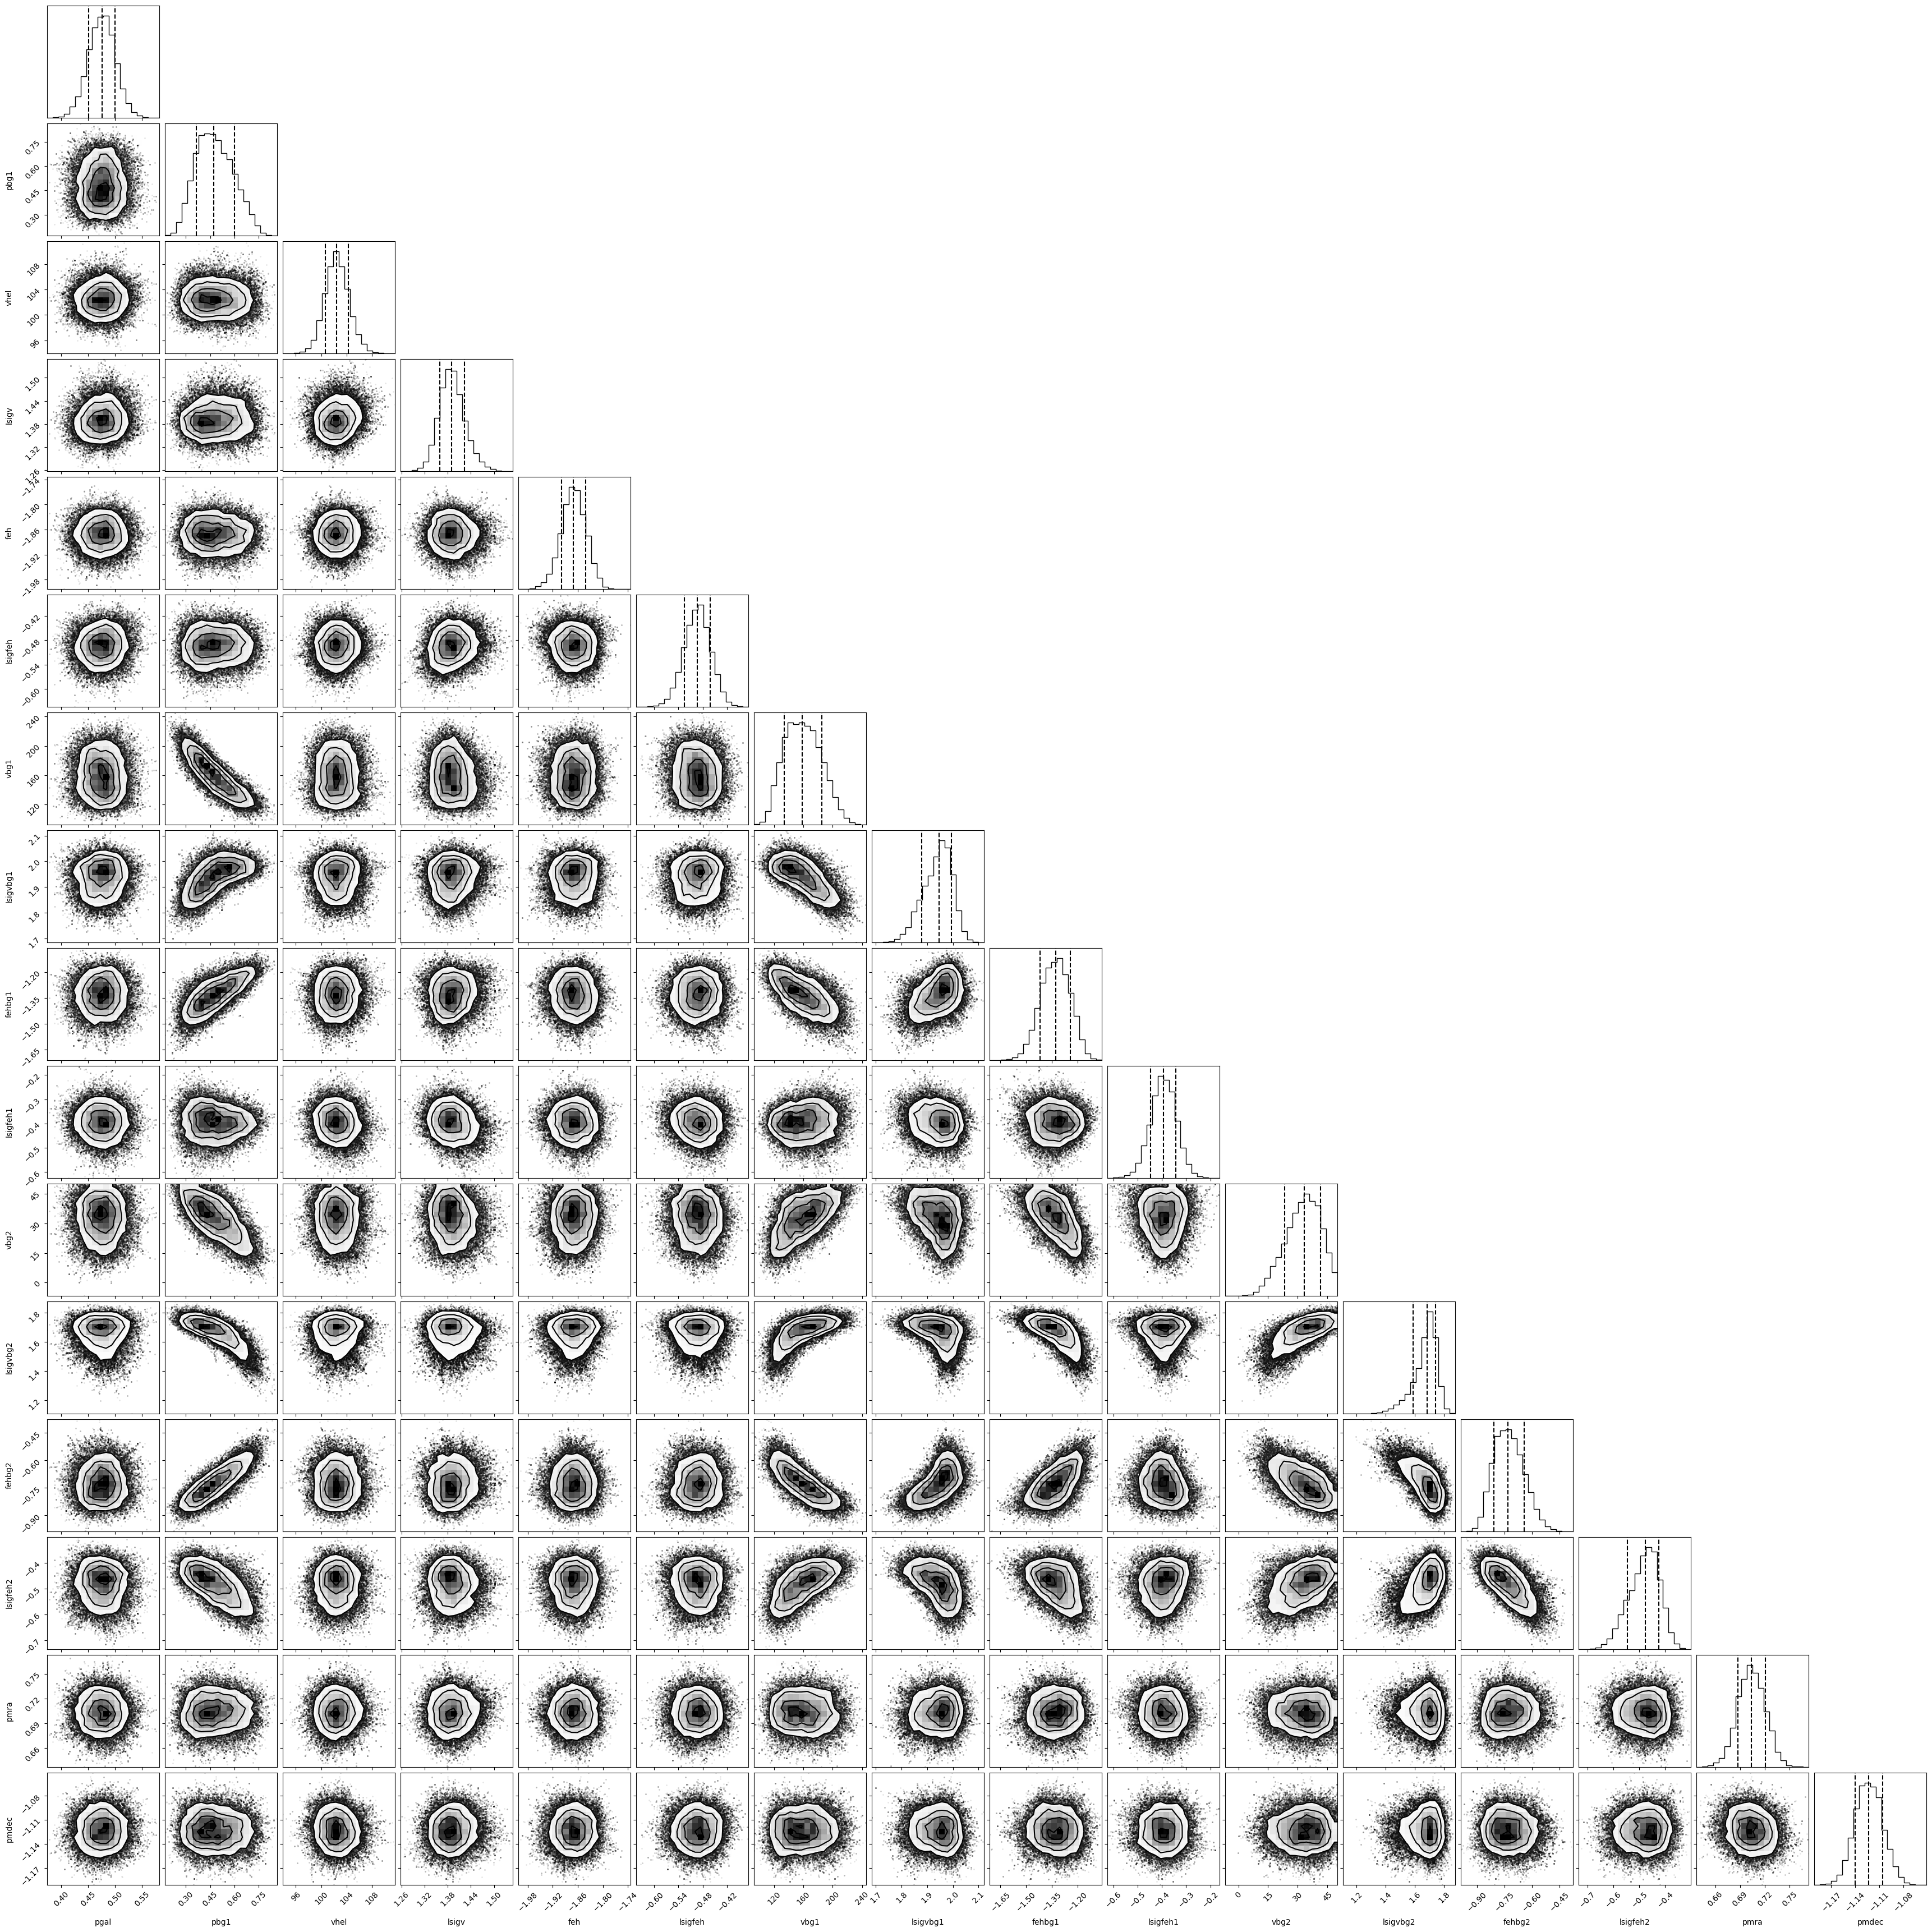

In [52]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84])
plt.savefig('smcnod_full_emcee.png')

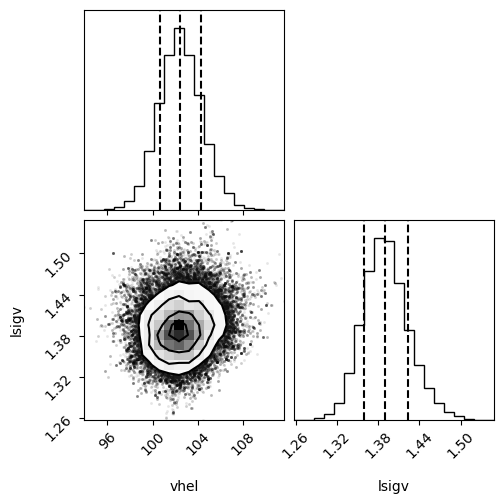

In [53]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84])

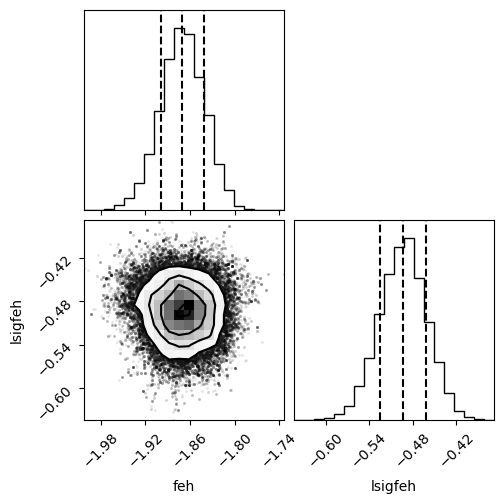

In [55]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84])

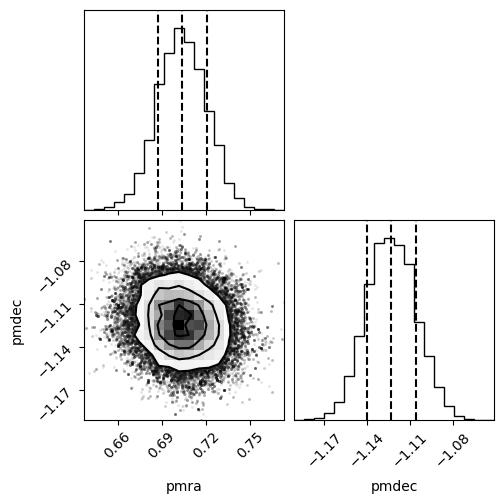

In [56]:
fig3 = corner.corner(outputs[:,14:16], labels=param_labels[14:16], quantiles=[0.16,0.50,0.84])

In [57]:
# assume distribution is symmetric about the mean
# process the chain to get mu and sigma
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, median)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, median)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [58]:
meds, errs = process_chain(outputs)

In [59]:
# mcmc results and error
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.475 0.024
pbg1 0.472 0.119
vhel 102.413 1.832
lsigv 1.389 0.033
feh -1.870 0.030
lsigfeh -0.493 0.032
vbg1 158.213 25.773
lsigvbg1 1.946 0.057
fehbg1 -1.329 0.087
lsigfeh1 -0.393 0.052
vbg2 33.288 9.132
lsigvbg2 1.685 0.076
fehbg2 -0.731 0.083
lsigfeh2 -0.476 0.061
pmra 0.704 0.016
pmdec -1.123 0.017


In [60]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = "]
def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.475
pbg1 =  0.472
vhel =  102.413
lsigv =  1.389
feh =  -1.870
lsigfeh =  -0.493
vbg1 =  158.213
lsigvbg1 =  1.946
fehbg1 =  -1.329
lsigfeh1 =  -0.393
vbg2 =  33.288
lsigvbg2 =  1.685
fehbg2 =  -0.731
lsigfeh2 =  -0.476
pmra =  0.704
pmdec =  -1.123
